In [1]:
import numpy as np
import sklearn
import pandas as pd
from PIL import Image
import os
import seaborn as sns
import matplotlib.pyplot as plt
from skimage.measure import block_reduce
from sklearn.cluster import MeanShift
import sklearn.cluster

In [2]:
import sklearn.model_selection
import sklearn.ensemble
import sklearn.metrics
import sklearn.neighbors
import sklearn.decomposition
import sklearn.svm
import sklearn.naive_bayes
import sklearn.neural_network
import winsound
from scipy.ndimage import rotate

In [3]:
data = {'gt':[], 'nt':[], 'mt':[], 'pt':[]}
KEY = ['gt', 'nt', 'mt', 'pt']

def im_to_arr(dfl:list, path:str):
    filenames = os.listdir(path=path)
    filen = len(filenames)
    for i in range(filen):
        img = Image.open(path+'/'+filenames[i]).convert('L')
        dfl.append([np.asarray(img), img])

In [4]:
im_to_arr(data['gt'], "tumor_dataset/Training/glioma_tumor")
im_to_arr(data['nt'], "tumor_dataset/Training/no_tumor")
im_to_arr(data['mt'], "tumor_dataset/Training/meningioma_tumor")
im_to_arr(data['pt'], "tumor_dataset/Training/pituitary_tumor")

In [5]:
def imageshow(arr:np.ndarray):
    plt.figure(figsize=(5, 5))
    plt.imshow(arr, cmap='gray')
    plt.axis('off')
    plt.show()

def endbeep():
    fr = 2000    # range : 37 ~ 32767
    du = 200     # 1000 ms ==1second
    winsound.Beep(fr, du)
    winsound.Beep(fr, du)

In [6]:
def imgshow5x5(l:list, order=False) -> list:
    imgtable = [l[i] for i in np.random.choice(list(range(len(l))), size=25, replace=False)] \
        if not order else [l[i] for i in order]
    fig, axes = plt.subplots(5, 5, figsize=(10, 10))

    for i in range(5):
        for j in range(5):
            axes[i, j].imshow(imgtable[i*5+j], cmap='gray')
            axes[i, j].axis('off')
            
    plt.show()
    return imgtable

In [7]:
def delete_bg(imgarr:np.ndarray, img:Image) -> list:
    ''' return `True` if img is 512x512 for third value. '''
    margin = [[-1,-1],[-1,-1]]
    wh = img.size
    for i in range(2):
        max_col = imgarr.max(axis=i)
        arr = max_col >= 40; streak = [0,0]; ssp = [-1,-1]; flag = 0
        for j in range(wh[i]):
            if flag == 2: break
            if margin[i][0] == -1:
                if arr[j]:
                    streak[0] += 1
                    if ssp[0] == -1: ssp[0] = j
                    if streak[0] >= wh[i]//7:
                        margin[i][0] = ssp[0]; flag += 1
                else: streak[0] = 0; ssp[0] = -1
            if margin[i][1] == -1:
                if arr[-j-1]:
                    streak[1] += 1
                    if ssp[1] == -1: ssp[1] = wh[i]-j
                    if streak[1] >= wh[i]//7:
                        margin[i][1] = ssp[1]; flag += 1
                else: streak[1] = 0; ssp[1] = -1
        # margin[i][0] = np.argmax(max_col >= 40); margin[i][1] = wh[i] - np.argmax(np.flip(max_col) >= 40)
    timg = img.crop((margin[0][0],margin[1][0],margin[0][1],margin[1][1])).resize((512,512))
    timgarr = np.asarray(timg)
    
    return [timgarr, timg, wh[0] == 512 and wh[1] == 512]

In [8]:
for k in KEY:
    length = len(data[k])
    for i in range(length):
        data[k][i] = delete_bg(data[k][i][0], data[k][i][1])
    for i in range(length):
        ang = (1 if np.random.randint(0,2) else -1) * (np.random.random() * 3 + 3)
        rotated = rotate(data[k][i][0], angle=ang, axes=(1, 0), reshape=False, mode='constant', cval=0)
        data[k].append([rotated, -1, data[k][i][2]])
    # for i in range(length):
    #     fliped = data[k][i][1].transpose(Image.FLIP_LEFT_RIGHT)
    #     data[k].append([np.asarray(fliped), fliped, data[k][i][2]])
    for i in range(length*2):
        shift_x = (1 if np.random.randint(0,2) else -1) * np.random.randint(8, 23)
        shift_y = (1 if np.random.randint(0,2) else -1) * np.random.randint(8, 23)
        moved = np.roll(data[k][i][0], (shift_x, shift_y), axis=(1, 0))
        if shift_x > 0:
            moved[:, :shift_x] = 0
        elif shift_x < 0:
            moved[:, shift_x:] = 0
        if shift_y > 0:
            moved[:shift_y, :] = 0
        elif shift_y < 0:
            moved[shift_y:, :] = 0
        data[k].append([moved, -1, data[k][i][2]])


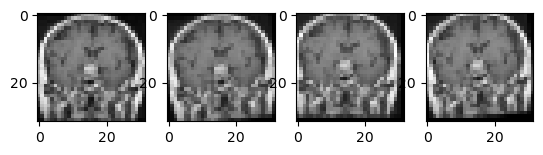

In [9]:
fig,axes = plt.subplots(1, 4)
for i in range(4):
    axes[i].imshow(block_reduce(data['pt'][827*i+3][0], (16,16), np.average), cmap='gray')

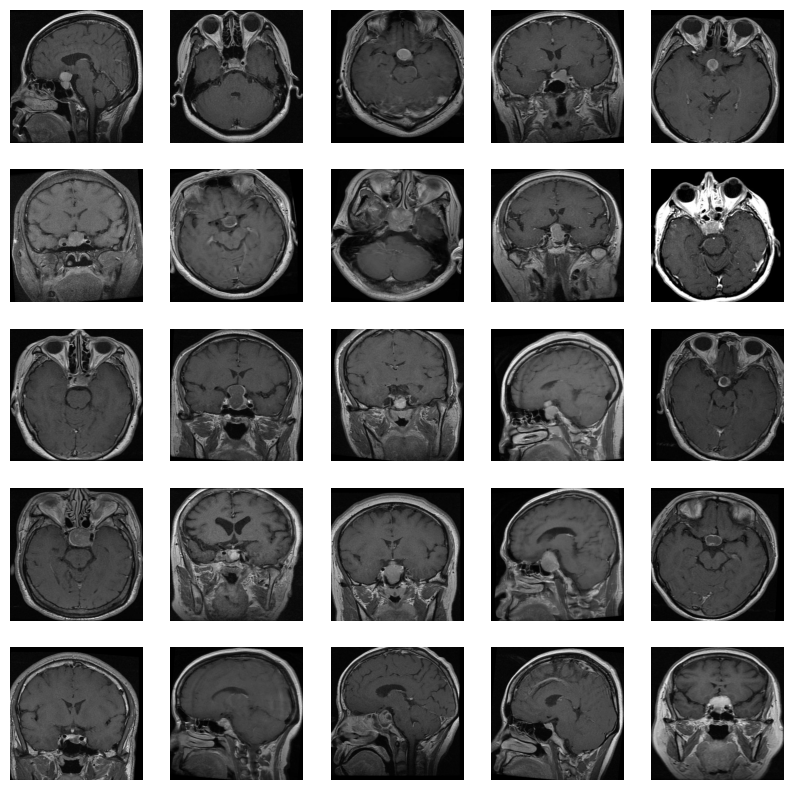

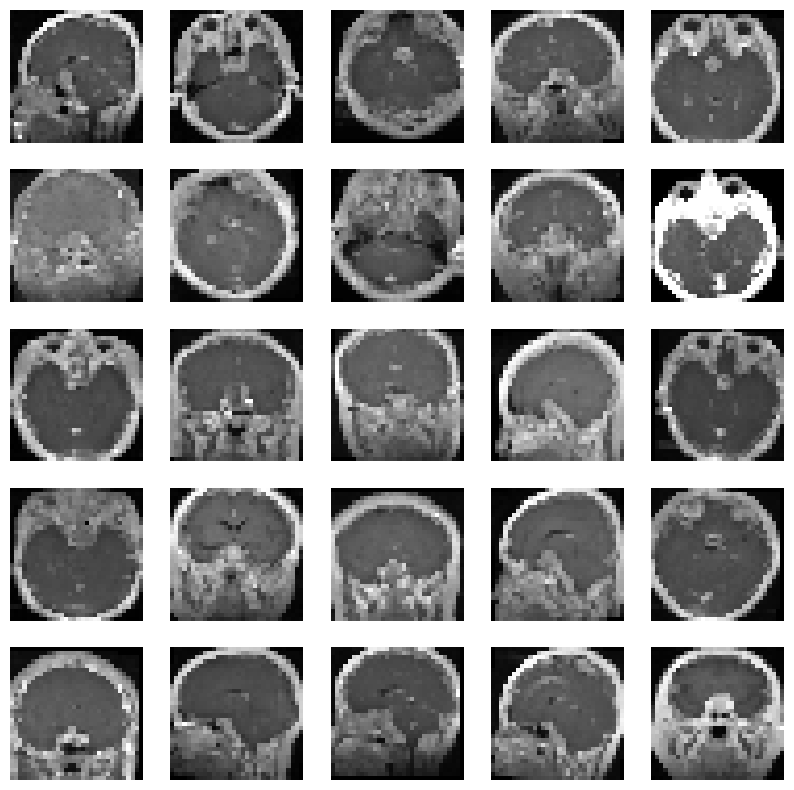

In [10]:
imgtable = imgshow5x5(list(map(lambda x: x[0], data['pt'])))
pooled = [block_reduce(np.asarray(imgtable[i]), (16, 16), np.max) for i in range(25)]
_ = imgshow5x5(pooled, order=list(range(25)))

0.8996588373847269


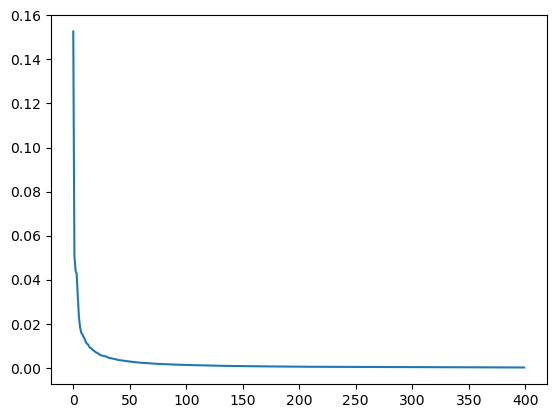

In [11]:
all_pooled = []; all_y = []; i = 0; kpool = 8; output = []
for k in KEY:
    data_len = len(data[k])
    all_pooled += [block_reduce(data[k][i][0], (kpool, kpool), np.average).reshape((512//kpool) ** 2) for i in range(data_len)]
    # all_pooled += [data[k][i][0].reshape(512 ** 2) for i in range(data_len)]
    all_y += [i for _ in range(data_len)]
    i += 1

# for i in range(len(all_pooled)):
#     output.append(all_pooled[i] / np.max(all_pooled[i]))
output = all_pooled

pca = sklearn.decomposition.PCA(n_components=400)
pca.fit(output)
print(np.sum(pca.explained_variance_ratio_))
plt.plot(pca.explained_variance_ratio_)
output = pca.transform(output)

# imgsize_col = []
# for k in data.keys():
#     imgsize_col += list(map(lambda x:x[2]*300, data[k]))
# imgsize_col = np.array(imgsize_col).reshape(-1, 1)
# output = np.concatenate([output, imgsize_col], axis=1)

In [12]:
al = []; iter_num = 10; wrong_list = []
for _ in range(iter_num):
    seed = np.random.randint(0, 100000)
    X_train, X_test, y_train, y_test = \
    sklearn.model_selection.train_test_split(output, all_y, test_size=0.1, shuffle=True, random_state=seed)
    model1 = sklearn.svm.SVC(C=2.0, probability=True)
    model2 = sklearn.neighbors.KNeighborsClassifier(n_neighbors=4, p=2, weights='distance')
    #model3 = sklearn.ensemble.RandomForestClassifier(n_estimators=400)
    model3 = sklearn.neural_network.MLPClassifier(hidden_layer_sizes=(150,), learning_rate='adaptive', solver='sgd')
    model = sklearn.ensemble.VotingClassifier([("SVM", model1), ("KNN", model2), ("MLP", model3)], voting="soft", weights=[.4,.3,.4])
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    al.append(sklearn.metrics.accuracy_score(y_pred, y_test))
    wrong_list.append(np.unique(np.array(y_test)[y_test != y_pred], return_counts=True))
print(sum(al)/len(al))
#endbeep()

0.9220383275261324


In [13]:
wrong_indices = np.where(y_pred != y_test)[0]
data_number = [len(data[k]) for k in KEY]
print(np.unique(np.array(y_test), return_counts=True))
for i in range(len(wrong_list)):
    print(wrong_list[i])

(array([0, 1, 2, 3]), array([336, 157, 326, 329], dtype=int64))
(array([0, 1, 2, 3]), array([23, 14, 43, 14], dtype=int64))
(array([0, 1, 2, 3]), array([25, 12, 37, 13], dtype=int64))
(array([0, 1, 2, 3]), array([24, 18, 35,  9], dtype=int64))
(array([0, 1, 2, 3]), array([23, 13, 36, 19], dtype=int64))
(array([0, 1, 2, 3]), array([28, 14, 29, 11], dtype=int64))
(array([0, 1, 2, 3]), array([20,  8, 48, 10], dtype=int64))
(array([0, 1, 2, 3]), array([29, 12, 50, 10], dtype=int64))
(array([0, 1, 2, 3]), array([23, 10, 44, 16], dtype=int64))
(array([0, 1, 2, 3]), array([18,  7, 44, 19], dtype=int64))
(array([0, 1, 2, 3]), array([26, 15, 22, 24], dtype=int64))


0 2


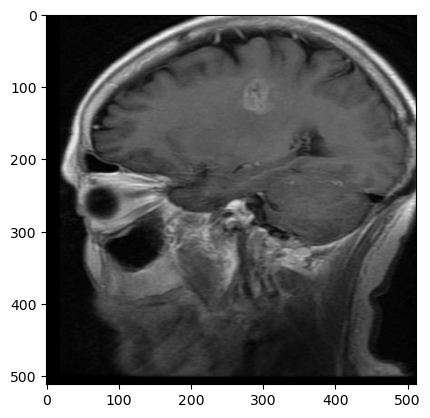

In [62]:
random_wrong_index = wrong_indices[np.random.randint(0, len(wrong_indices))]
random_output_index = np.where(output == X_test[random_wrong_index])[0][0]
for i in range(4):
    if random_output_index < data_number[i]:
        k = KEY[i]; break
    else: random_output_index -= data_number[i]
print(y_test[random_wrong_index], y_pred[random_wrong_index])
plt.imshow(data[k][random_output_index][0], cmap='gray')

In [15]:
al

[0.9181184668989547,
 0.9242160278745645,
 0.9250871080139372,
 0.9207317073170732,
 0.9285714285714286,
 0.9250871080139372,
 0.912020905923345,
 0.9189895470383276,
 0.9233449477351916,
 0.9242160278745645]

mt


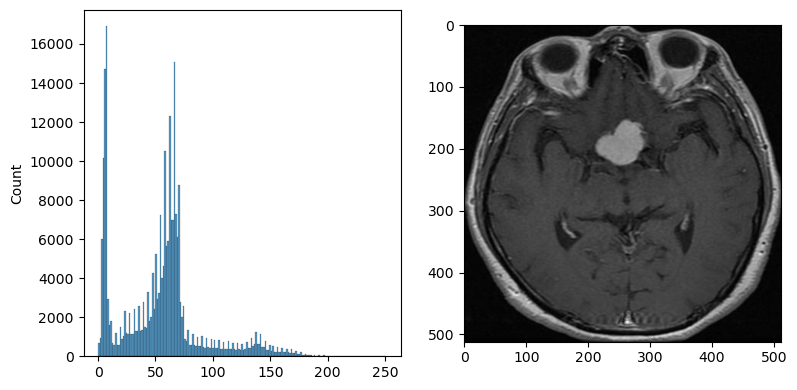

In [71]:
fig, axes = plt.subplots(1,2, figsize=(9, 4.5))
randidx = np.random.randint(0, 1000); k = KEY[randidx%4]; print(k)
sns.histplot(data[k][randidx][0].reshape(512*512,),ax=axes[0])
data[k][randidx][0].reshape(512*512,).mean()
axes[1].imshow(data[k][randidx][0], cmap='gray')

In [17]:
# model = sklearn.svm.SVC()
# param_grid = {'C':[0.2, 1, 2], 'tol':[0.001, 0.005, 0.0001], 'max_iter':[None, 1000, 500, 200]}
# grid_search = sklearn.model_selection.GridSearchCV(model, param_grid, cv=4, scoring='accuracy')

# grid_search.fit(X_train, y_train)
# print("최적 하이퍼파라미터: ", grid_search.best_params_)
# print("최적 모델의 정확도: ", grid_search.best_score_)

# # 최적 모델로 예측
# y_pred = grid_search.best_estimator_.predict(X_test)

# # 성능 평가
# accuracy = sklearn.metrics.accuracy_score(y_test, y_pred)
# print("테스트 세트 정확도: ", accuracy)